In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def dataprep(pasture_type):
    read_file = pasture_type+'_data.csv'
    df = pd.read_csv(read_file)
    print(df.info())
    # replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    y = df['FOO']
    X = df.drop(['FOO'], axis=1)
    
    # Create the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #X_train_climate = X_train.drop(['ANIMAL_LOAD_DAYS','PERCENTAGE_OF_DAYS_GRAZED'], axis = 1)
    #X_train_climate.drop(X_train_climate.filter(regex='vegetationclass|improvement|soilname').columns, axis=1, inplace=True)
    #X_test_climate = X_test.drop(['ANIMAL_LOAD_DAYS','PERCENTAGE_OF_DAYS_GRAZED'], axis = 1)
    #X_test_climate.drop(X_test_climate.filter(regex='vegetationclass|improvement|soilname').columns, axis=1, inplace=True)
    names = list(X_train.columns)

    print('XGBoost')
    # Instantiatethe XGBRegressor: xg_reg
    xg_climate = xgb.XGBRegressor(objective='reg:squarederror', seed=42, n_estimators=20, max_depth=8, reg_lambda = 0)

    # Fit the regressor to the training set
    xg_climate.fit(X_train, y_train)

    # Predict the labels of the test set: preds
    preds_xg_climate = xg_climate.predict(X_test)
    # compute the rmse: rmse
    rmse_xg_climate = np.sqrt(mean_squared_error(y_test, preds_xg_climate))
    print("\tRMSE: %0.2f" % (rmse_xg_climate))

    # compute the mae: mae
    mae_xg_climate = mean_absolute_error(y_test, preds_xg_climate)
    print("\tMAE: %0.2f" % (mae_xg_climate))

    #r2 score
    print("\tR2 score:", round(r2_score(y_test,preds_xg_climate),2))

    print('Gain')
    xg_climate.get_booster().feature_names = names
    # importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    f = 'gain'
    D =xg_climate.get_booster().get_score(importance_type= f)
    D=dict(sorted(D.items(), key=lambda item: item[1]))
    D_sorted = dict(list(D.items())[-20:])
    plt.figure(figsize=(10,10))
    plt.barh(*zip(*D_sorted.items()))
    plt.xlabel("Feature Importance")
    plt.show()
    
    keys_to_remove = [ '3D_MAX_TEMP','5D_MAX_TEMP','7D_MAX_TEMP','10D_MAX_TEMP','14D_MAX_TEMP','30D_MAX_TEMP','90D_MAX_TEMP','180D_MAX_TEMP','365D_MAX_TEMP',
                  '3D_MIN_TEMP','5D_MIN_TEMP','7D_MIN_TEMP','10D_MIN_TEMP','14D_MIN_TEMP','30D_MIN_TEMP','90D_MIN_TEMP','180D_MIN_TEMP','365D_MIN_TEMP']

    for key in keys_to_remove:
        D.pop(key, None)
        
    data = D
    rename_map = {
        'RH_TMIN': '0DAVG_RH_TMIN',
        'RH_TMAX': '0DAVG_RH_TMAX',
        'EVAP': '0DAVG_EVAP',
        'RAIN': '0DAVG_RAIN',
        'MIN_TEMP': '0DAVG_MIN_TEMP',
        'MAX_TEMP': '0DAVG_MAX_TEMP',
        'RADIATION': '0DAVG_RADIATION'
    }

    # Rename keys based on the mapping
    data = {rename_map.get(key, key): value for key, value in data.items()}

    # Step 1: Extract time horizons and attributes
    parsed_data = []
    for key, value in data.items():
        parts = key.split('_')  # Split by '_'
        if len(parts) > 1:
            horizon = parts[0]  # Time horizon (e.g., 3D, 5D)
            attribute = '_'.join(parts[1:])  # Remaining part of the attribute
        else:
            horizon = 'Static'  # Static attributes with no time horizon
            attribute = key
        parsed_data.append({'Horizon': horizon, 'Attribute': attribute, 'Value': value})

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(parsed_data)
    # Step 3: Define custom order for time horizons
    horizon_order = ['0DAVG', '3DAVG', '5DAVG', '7DAVG', '10DAVG', '14DAVG', '30DAVG', '90DAVG', '180DAVG', '365DAVG']
    df['Horizon'] = pd.Categorical(df['Horizon'], categories=horizon_order, ordered=True)
    # Step 4: Pivot the data for heatmap format
    heatmap_data = df.pivot(index='Attribute', columns='Horizon', values='Value')

    # Step 5: Normalize the values for each climate attribute (row-wise normalization)
    heatmap_data_normalized = heatmap_data.div(heatmap_data.max(axis=1), axis=0).fillna(0)  # Fill NaNs with 0

    # Step 6: Create the heatmap with a sequential red colormap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data_normalized, annot=False, cmap='Reds', cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)
    plt.title('Normalized Climate Attributes Heatmap by Time Horizon')
    plt.xlabel('Time Horizon')
    plt.ylabel('Climate Attribute')
    plt.tight_layout()
    plt.show()
    return heatmap_data_normalized
    #print('Total Gain')
    #xg_climate.get_booster().feature_names = names
    # importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    #f = 'total_cover'
    #D =xg_climate.get_booster().get_score(importance_type= f)
    #D=dict(sorted(D.items(), key=lambda item: item[1]))
    #D_sorted = dict(list(D.items())[-20:])
    #plt.figure(figsize=(10,10))
    #plt.barh(*zip(*D_sorted.items()))
    #plt.xlabel("Feature Importance")
    #plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   3DAVG_RAIN         8154 non-null   float64
 1   3DAVG_MAX_TEMP     8154 non-null   float64
 2   3DAVG_MIN_TEMP     8154 non-null   float64
 3   3DAVG_RH_TMAX      8154 non-null   float64
 4   3DAVG_RH_TMIN      8154 non-null   float64
 5   3DAVG_EVAP         8154 non-null   float64
 6   3DAVG_RADIATION    8154 non-null   float64
 7   3D_MIN_TEMP        8154 non-null   float64
 8   3D_MAX_TEMP        8154 non-null   float64
 9   5DAVG_RAIN         8154 non-null   float64
 10  5DAVG_MAX_TEMP     8154 non-null   float64
 11  5DAVG_MIN_TEMP     8154 non-null   float64
 12  5DAVG_RH_TMAX      8154 non-null   float64
 13  5DAVG_RH_TMIN      8154 non-null   float64
 14  5DAVG_EVAP         8154 non-null   float64
 15  5DAVG_RADIATION    8154 non-null   float64
 16  5D_MIN_TEMP        8154 

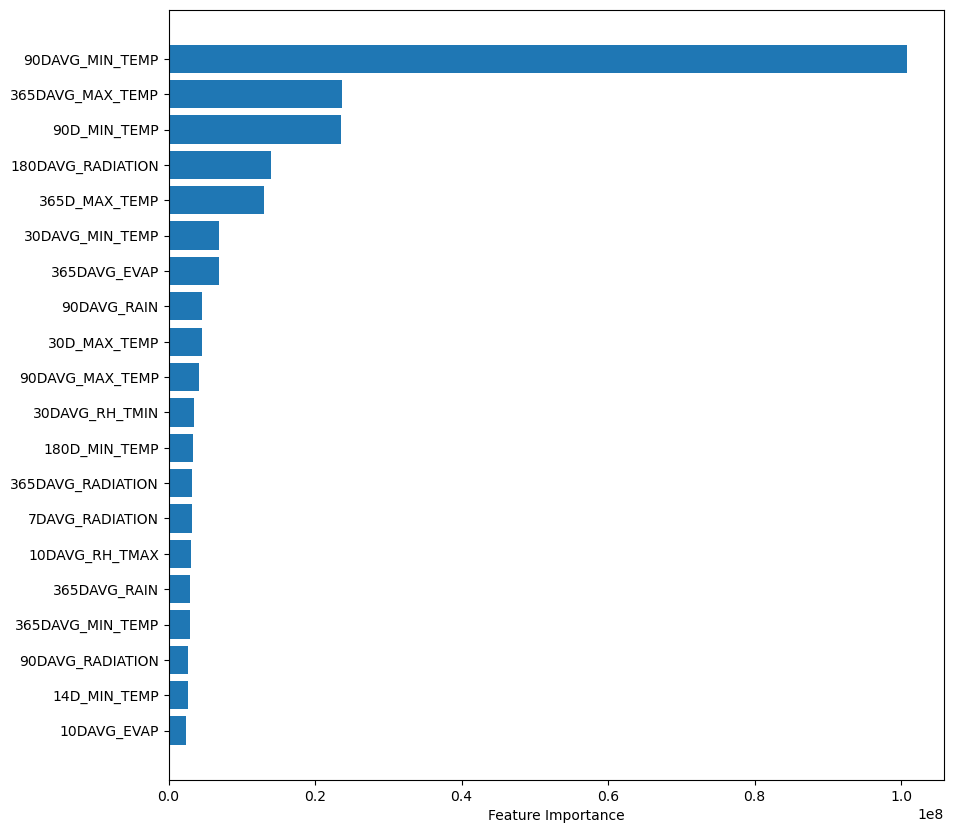

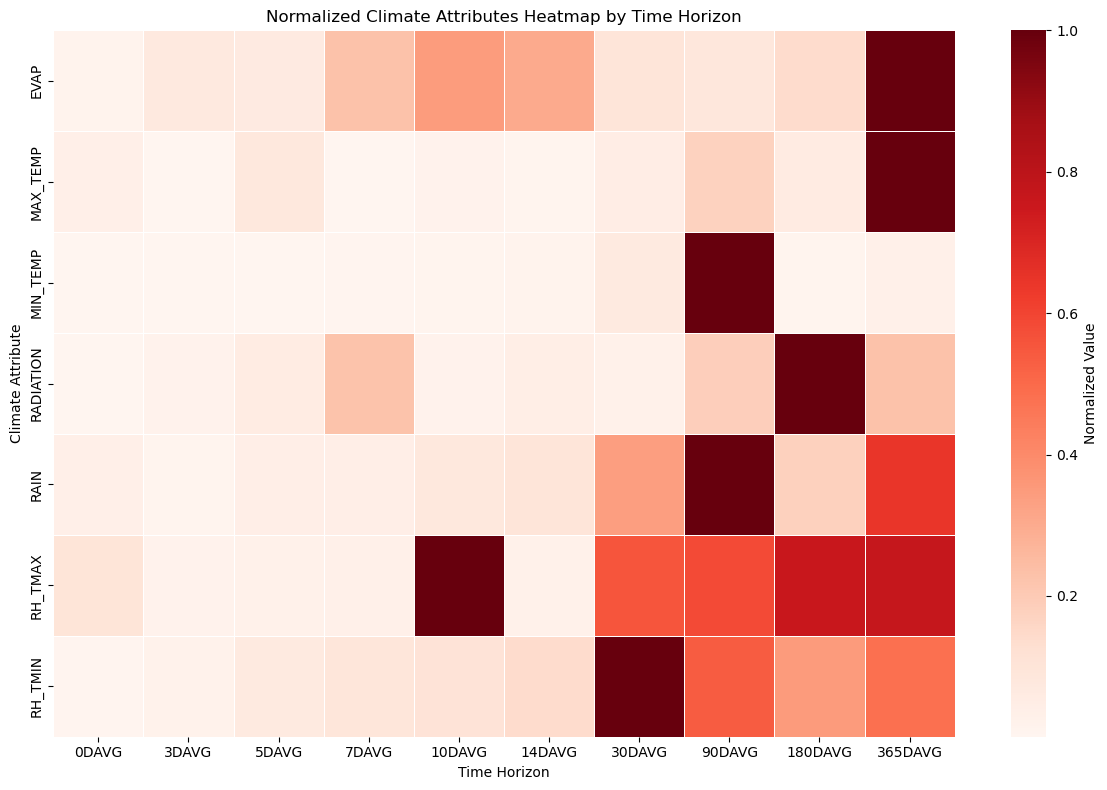

In [3]:
hm_phalaris = dataprep('Phalaris')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14423 entries, 0 to 14422
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   3DAVG_RAIN         14423 non-null  float64
 1   3DAVG_MAX_TEMP     14423 non-null  float64
 2   3DAVG_MIN_TEMP     14423 non-null  float64
 3   3DAVG_RH_TMAX      14423 non-null  float64
 4   3DAVG_RH_TMIN      14423 non-null  float64
 5   3DAVG_EVAP         14423 non-null  float64
 6   3DAVG_RADIATION    14423 non-null  float64
 7   3D_MIN_TEMP        14423 non-null  float64
 8   3D_MAX_TEMP        14423 non-null  float64
 9   5DAVG_RAIN         14423 non-null  float64
 10  5DAVG_MAX_TEMP     14423 non-null  float64
 11  5DAVG_MIN_TEMP     14423 non-null  float64
 12  5DAVG_RH_TMAX      14423 non-null  float64
 13  5DAVG_RH_TMIN      14423 non-null  float64
 14  5DAVG_EVAP         14423 non-null  float64
 15  5DAVG_RADIATION    14423 non-null  float64
 16  5D_MIN_TEMP        144

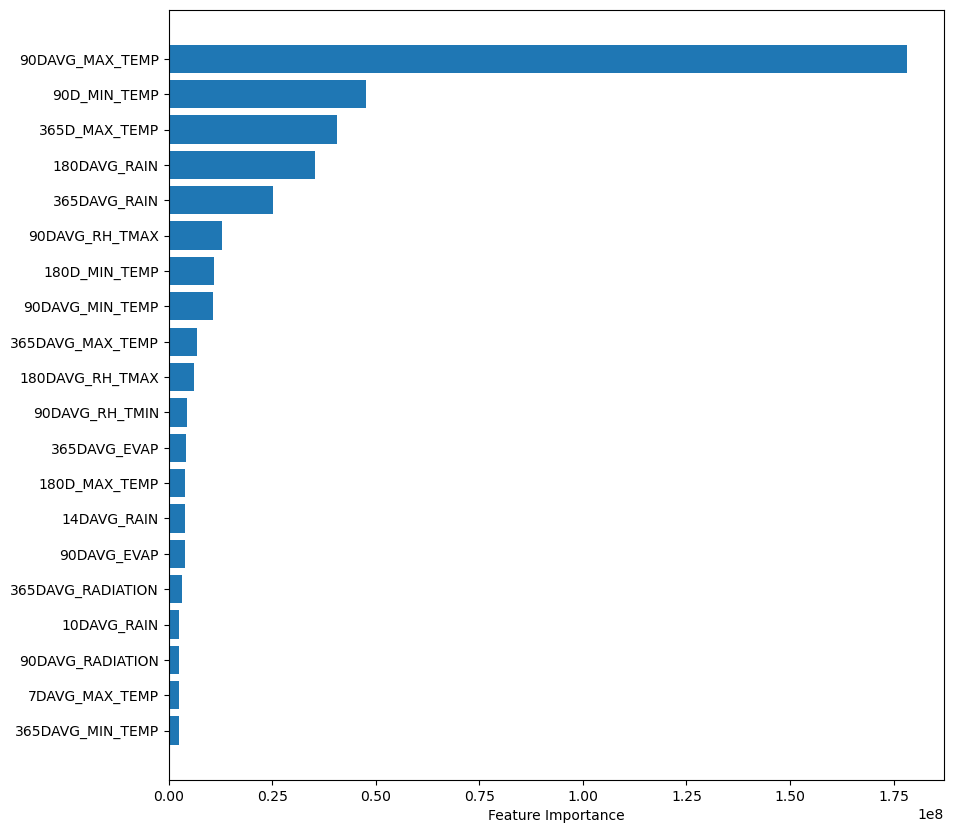

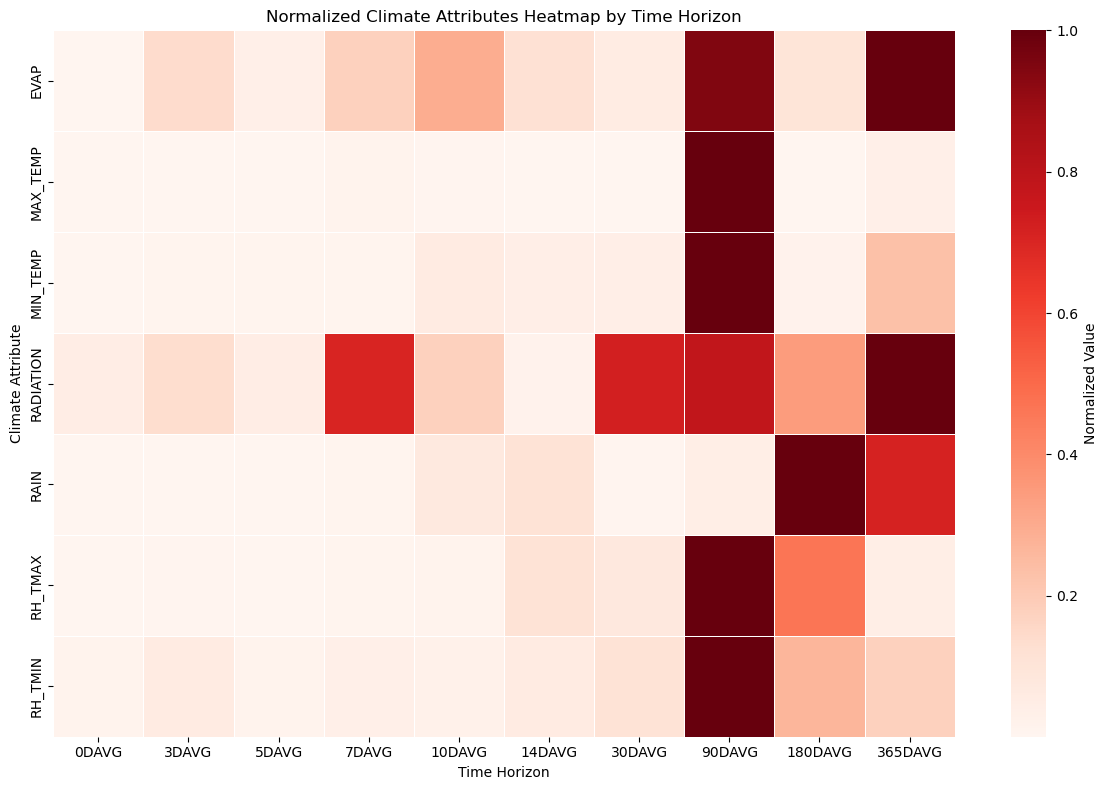

In [4]:
hm_pasture = dataprep('improved_pasture')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16745 entries, 0 to 16744
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   3DAVG_RAIN         16745 non-null  float64
 1   3DAVG_MAX_TEMP     16745 non-null  float64
 2   3DAVG_MIN_TEMP     16745 non-null  float64
 3   3DAVG_RH_TMAX      16745 non-null  float64
 4   3DAVG_RH_TMIN      16745 non-null  float64
 5   3DAVG_EVAP         16745 non-null  float64
 6   3DAVG_RADIATION    16745 non-null  float64
 7   3D_MIN_TEMP        16745 non-null  float64
 8   3D_MAX_TEMP        16745 non-null  float64
 9   5DAVG_RAIN         16745 non-null  float64
 10  5DAVG_MAX_TEMP     16745 non-null  float64
 11  5DAVG_MIN_TEMP     16745 non-null  float64
 12  5DAVG_RH_TMAX      16745 non-null  float64
 13  5DAVG_RH_TMIN      16745 non-null  float64
 14  5DAVG_EVAP         16745 non-null  float64
 15  5DAVG_RADIATION    16745 non-null  float64
 16  5D_MIN_TEMP        167

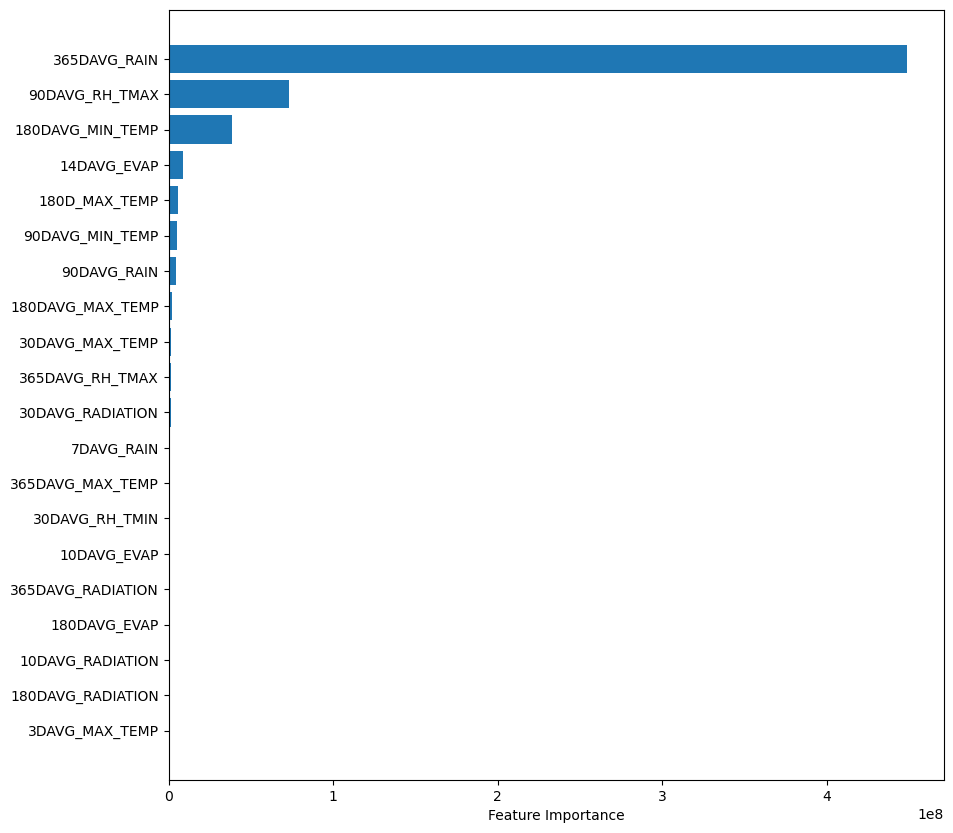

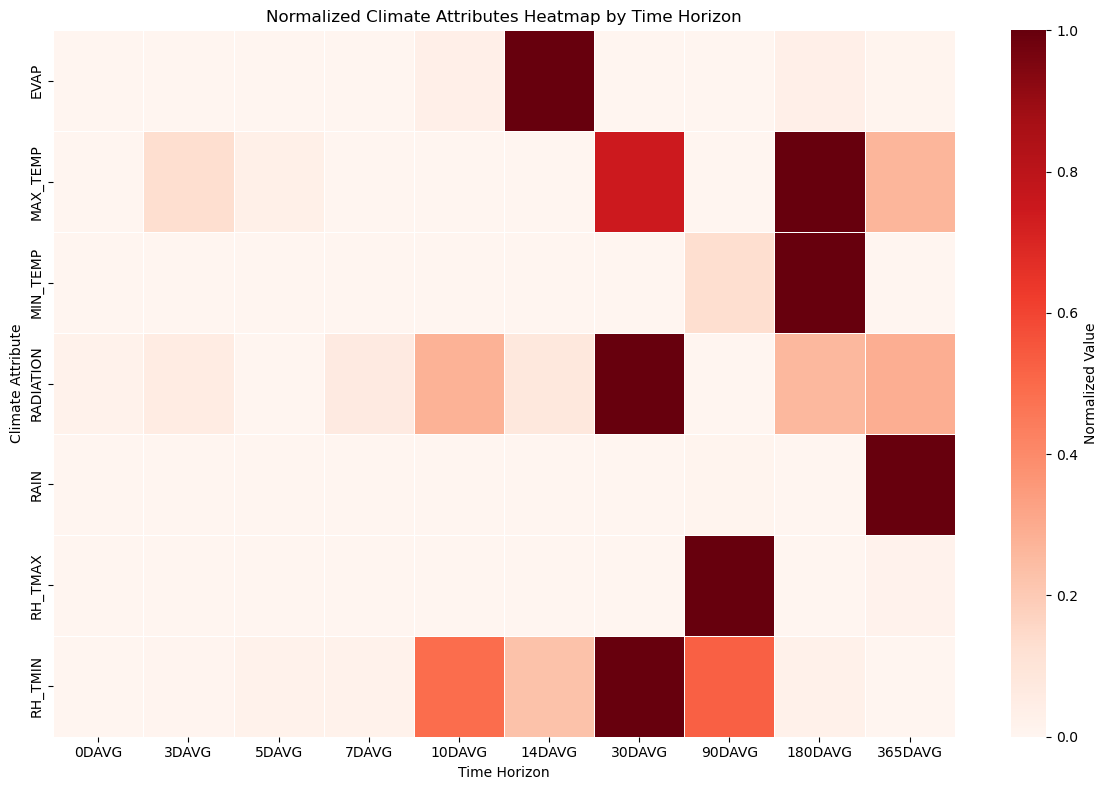

In [5]:
hm_clover_rye = dataprep('clover_rye_grass')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22970 entries, 0 to 22969
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   3DAVG_RAIN         22970 non-null  float64
 1   3DAVG_MAX_TEMP     22970 non-null  float64
 2   3DAVG_MIN_TEMP     22970 non-null  float64
 3   3DAVG_RH_TMAX      22970 non-null  float64
 4   3DAVG_RH_TMIN      22970 non-null  float64
 5   3DAVG_EVAP         22970 non-null  float64
 6   3DAVG_RADIATION    22970 non-null  float64
 7   3D_MIN_TEMP        22970 non-null  float64
 8   3D_MAX_TEMP        22970 non-null  float64
 9   5DAVG_RAIN         22970 non-null  float64
 10  5DAVG_MAX_TEMP     22970 non-null  float64
 11  5DAVG_MIN_TEMP     22970 non-null  float64
 12  5DAVG_RH_TMAX      22970 non-null  float64
 13  5DAVG_RH_TMIN      22970 non-null  float64
 14  5DAVG_EVAP         22970 non-null  float64
 15  5DAVG_RADIATION    22970 non-null  float64
 16  5D_MIN_TEMP        229

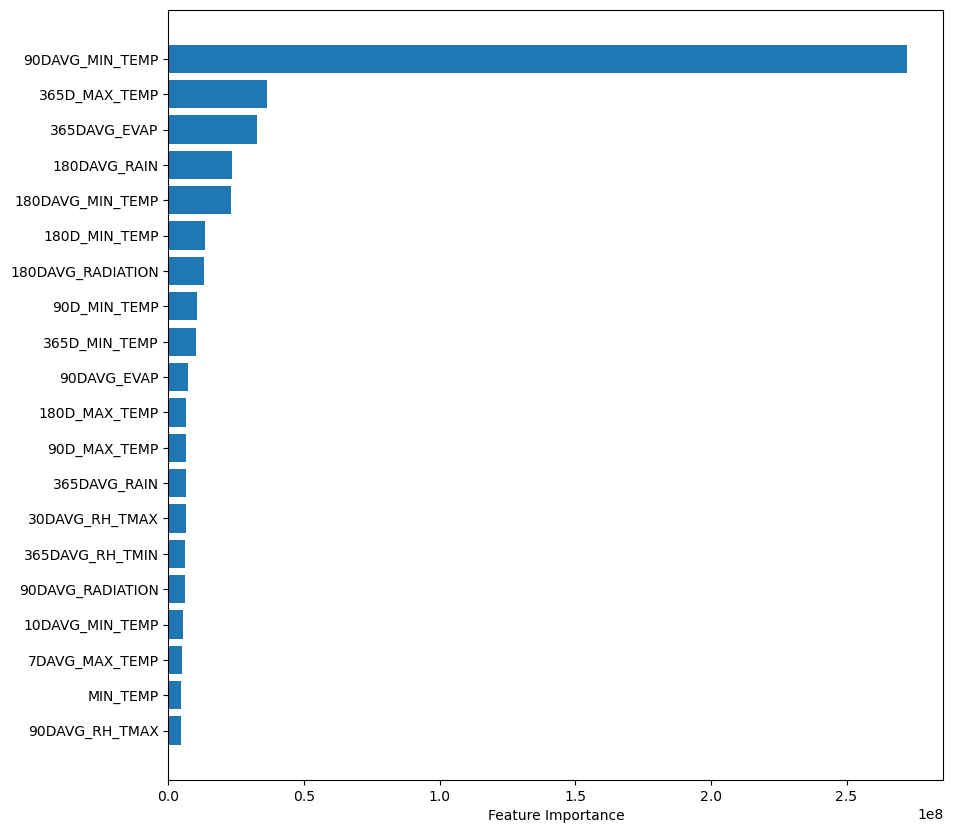

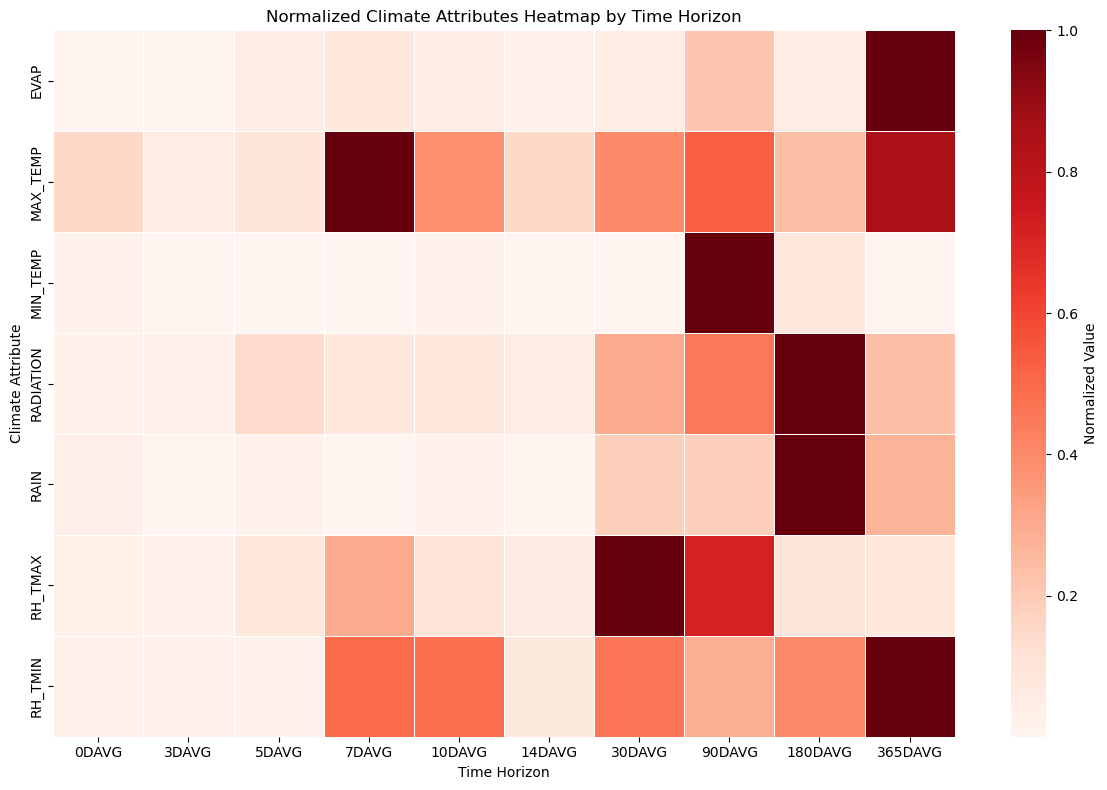

In [6]:
hm_lucerne = dataprep('lucerne')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426160 entries, 0 to 426159
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   3DAVG_RAIN         426160 non-null  float64
 1   3DAVG_MAX_TEMP     426160 non-null  float64
 2   3DAVG_MIN_TEMP     426160 non-null  float64
 3   3DAVG_RH_TMAX      426160 non-null  float64
 4   3DAVG_RH_TMIN      426160 non-null  float64
 5   3DAVG_EVAP         426160 non-null  float64
 6   3DAVG_RADIATION    426160 non-null  float64
 7   3D_MIN_TEMP        426160 non-null  float64
 8   3D_MAX_TEMP        426160 non-null  float64
 9   5DAVG_RAIN         426160 non-null  float64
 10  5DAVG_MAX_TEMP     426160 non-null  float64
 11  5DAVG_MIN_TEMP     426160 non-null  float64
 12  5DAVG_RH_TMAX      426160 non-null  float64
 13  5DAVG_RH_TMIN      426160 non-null  float64
 14  5DAVG_EVAP         426160 non-null  float64
 15  5DAVG_RADIATION    426160 non-null  float64
 16  5D

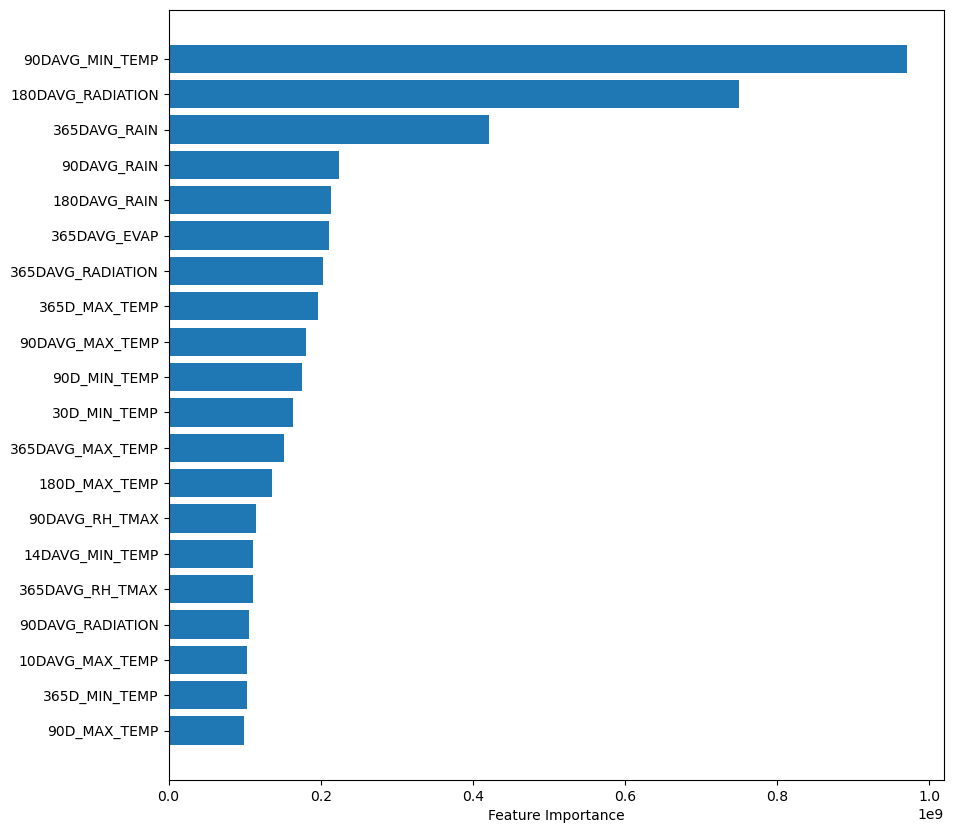

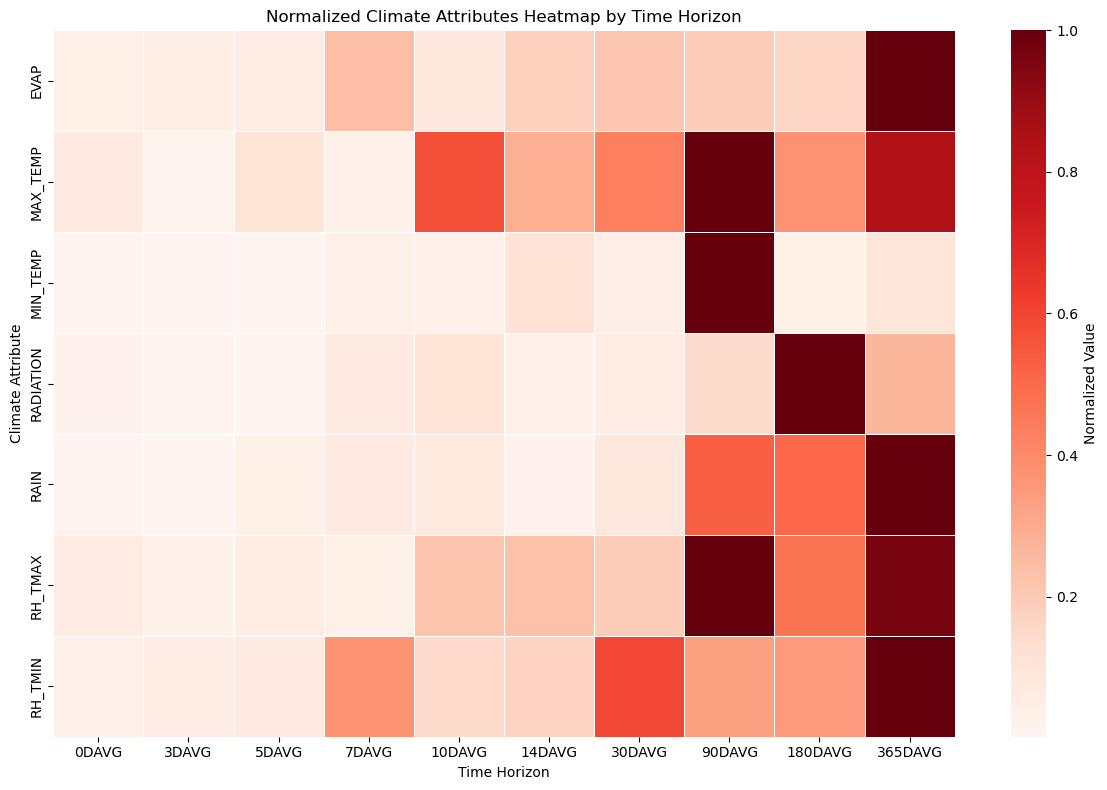

In [8]:
hm_natural_grass = dataprep('natural_grass')

In [9]:
hm_natural_grass

Horizon,0DAVG,3DAVG,5DAVG,7DAVG,10DAVG,14DAVG,30DAVG,90DAVG,180DAVG,365DAVG
Attribute,,,,,,,,,,
EVAP,0.036824,0.047864,0.050966,0.240690,0.078037,0.180304,0.214022,0.194839,0.165041,1.000000
MAX_TEMP,0.068467,0.013796,0.102043,0.026344,0.572332,0.286774,0.434638,1.000000,0.376505,0.838439
MIN_TEMP,0.007251,0.007485,0.011590,0.025872,0.030589,0.114877,0.042099,1.000000,0.034783,0.093852
RADIATION,0.019471,0.016075,0.013188,0.066352,0.109494,0.028236,0.055692,0.140214,1.000000,0.270069
RAIN,0.009118,0.001984,0.035772,0.066999,0.072585,0.021473,0.086194,0.530566,0.507817,1.000000
RH_TMAX,0.063783,0.025098,0.056931,0.034649,0.223299,0.235882,0.189939,1.000000,0.468537,0.967276
RH_TMIN,0.026006,0.049359,0.064590,0.373410,0.146719,0.166096,0.594031,0.334872,0.350370,1.000000


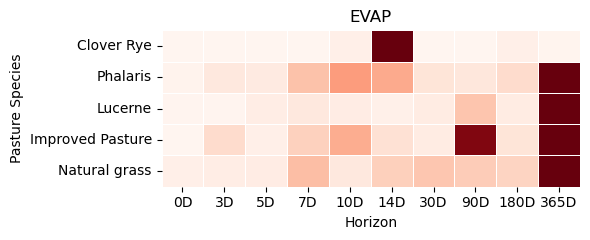

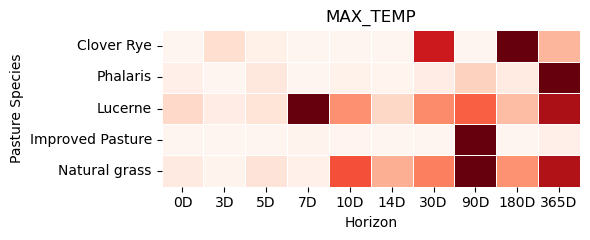

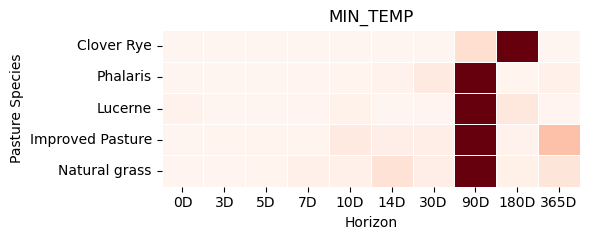

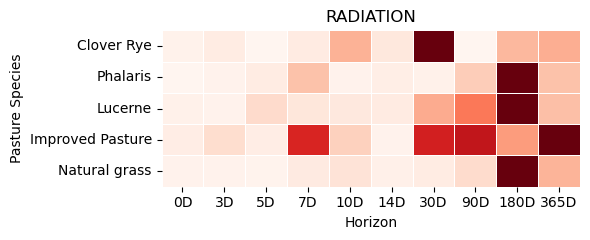

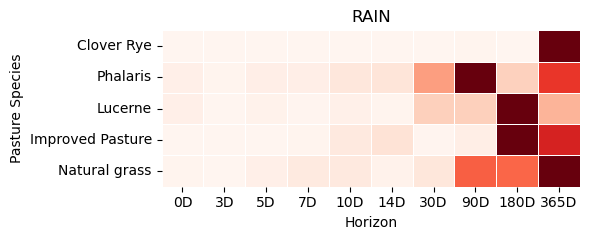

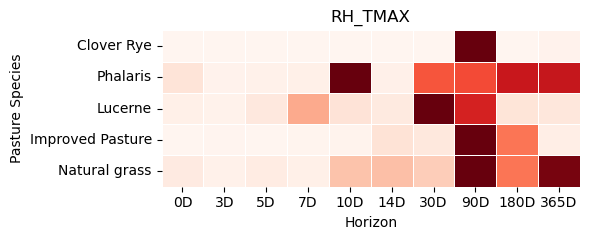

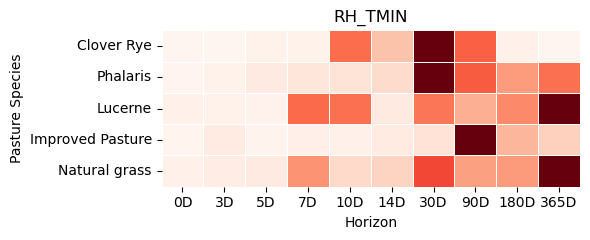

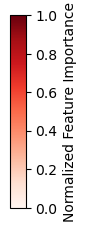

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


dataframes = {
    "Clover Rye": hm_clover_rye,
    "Phalaris": hm_phalaris,
    "Lucerne": hm_lucerne,
    "Improved Pasture": hm_pasture,
    "Natural grass": hm_natural_grass
}

# List of attributes to create heatmaps for
attributes = hm_pasture.index.tolist()

# Create a single dataframe for each attribute across species
for attribute in attributes:
    attribute_df = pd.DataFrame({species: df.loc[attribute] for species, df in dataframes.items()}).T
    
    # Remove 'AVG' from the horizon column names
    attribute_df.columns = attribute_df.columns.str.replace("AVG", "")
    
    # Set column name for better heatmap visualization
    attribute_df.columns.name = "Horizon"
    
    # Create the heatmap plot without a colorbar for each individual heatmap
    plt.figure(figsize=(6, 2.5))
    sns.heatmap(
        attribute_df, 
        annot=False, 
        cmap="Reds", 
        linewidths=0.5, 
        cbar=False  # Disable colorbar on individual heatmaps
    )
    plt.title(f"{attribute}")
    plt.ylabel("Pasture Species")
    plt.xlabel("Horizon")
    plt.tight_layout()
    plt.show()

# After all the heatmaps, create a single colorbar
fig, cbar_ax = plt.subplots(figsize=(0.2, 2.5))  # Adjust size for the colorbar
norm = plt.Normalize(vmin=min([df.min().min() for df in dataframes.values()]),
                     vmax=max([df.max().max() for df in dataframes.values()]))
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])  # Empty array for the colorbar
fig.colorbar(sm, cax=cbar_ax, label="Normalized Feature Importance")
plt.show()
